In [1]:
#imports
import spatialdata
import dask_image.imread
import dask.array as da
import geopandas as gpd
import anndata as ad
import napari_spatialdata
import time

import sys, os
sys.path.append(os.path.abspath("../functions/"))
import filtering
import anndata_utils

for package in [spatialdata, gpd, ad, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


spatialdata: 0.2.3
geopandas: 1.0.1
anndata: 0.11.3
napari_spatialdata: 0.5.3


In [2]:
# load sdata
sdata = spatialdata.read_zarr("../data/exemplar001/exemplar001.zarr")
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/exemplar001/exemplar001.zarr
├── Images
│     └── 'image': DataArray[cyx] (12, 3139, 2511)
├── Labels
│     └── 'mask': DataArray[yx] (3139, 2511)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (9711, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (9711, 12)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), mask_polygons (Shapes)

In [3]:
sdata['imaging'].var

,math,marker
DNA_6,DNA,6
ELANE,ELANE,
CD57,CD57,
CD45,CD45,
DNA_7,DNA,7
CD11B,CD11B,
SMA,SMA,
CD16,CD16,
DNA_8,DNA,8
ECAD,ECAD,


# Filter by value threshold in a feature

In [4]:
feature_to_filter = "DNA_6"

### Explore values of cells for DNA_6 feature

In [5]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def plot_dynamic_histogram(df, column, bins=100):
    """
    Create a dynamic histogram with a threshold slider, 
    showing counts to the left and right of the threshold.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to plot.
    """
    # Validate input
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    data = df[column].dropna()  # Handle missing values
    if data.empty:
        raise ValueError(f"No valid data in column '{column}'.")

    # Initial threshold
    initial_threshold = data.mean()  # Start at the mean as default

    # Function to calculate counts based on threshold
    def calculate_counts(data, threshold):
        left_count = (data < threshold).sum()
        right_count = (data >= threshold).sum()
        return left_count, right_count

    # Initial counts
    left_count, right_count = calculate_counts(data, initial_threshold)

    # Create figure
    fig = go.Figure()

    # Add histogram trace
    fig.add_trace(go.Histogram(x=data, nbinsx=bins, name=column))

    # Add initial annotations for counts
    fig.update_layout(
        annotations=[dict(x=0.02, y=1.1, xref="paper", yref="paper", text=f"Left Count: {left_count}", showarrow=False),
                    dict(x=0.98, y=1.1, xref="paper", yref="paper", text=f"Right Count: {right_count}", showarrow=False)]
    )

    # Initial vertical line at threshold
    fig.add_shape(
        type="line",
        x0=initial_threshold, y0=0, x1=initial_threshold, y1=1,
        xref="x", yref="paper",
        line=dict(color="red", width=2, dash="dash")
    )

    # Function to update both the annotations and line
    def update_slider(threshold):
        # Update counts
        left_count, right_count = calculate_counts(data, threshold)
        # Update annotations
        annotations = [
            dict(x=0.02, y=1.1, xref="paper", yref="paper", text=f"Left Count: {left_count}", showarrow=False),
            dict(x=0.98, y=1.1, xref="paper", yref="paper", text=f"Right Count: {right_count}", showarrow=False)]
        # Update line position
        shapes = [dict(
            type="line",
            x0=threshold, y0=0, x1=threshold, y1=1,
            xref="x", yref="paper",
            line=dict(color="red", width=2, dash="dash"))]
        return {"annotations": annotations, "shapes": shapes}

    # Add slider with threshold steps
    thresholds = np.linspace(data.min(), data.max(), bins)
    fig.update_layout(
        sliders=[{
            "active": 0,
            "currentvalue": {"prefix": "Threshold: "},
            "pad": {"t": 50},
            "steps": [
                {
                    "label": str(round(threshold, 2)),
                    "method": "relayout",
                    "args": [update_slider(threshold)]
                }
                for threshold in thresholds
            ]
        }]
    )

    # Show figure
    fig.show()

In [6]:
df = pd.DataFrame(data=sdata['imaging'].X, columns=sdata['imaging'].var_names)
plot_dynamic_histogram(df, feature_to_filter, bins=300)

In [7]:
# I decided from histogram that 5k is a good min threshold for the DNA_6 feature.
# I decided from histogram that 25k is a good max threshold for the DNA_6 feature. 
# I will now filter the data based on this threshold.

### Filtering by absolute value

In [8]:
# now visualize in sdata
sdata['imaging'] = filtering.filter_by_abs_value(
    adata=sdata['imaging'], 
    marker=feature_to_filter,
    value=5000,
    direction='above',
    plot=False)

2025-01-15 12:31:07.369 | INFO     | filtering:filter_by_abs_value:38 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-01-15 12:31:07.373 | INFO     | filtering:filter_by_abs_value:72 - Number of cells with DNA_6 above 5000: 9627
2025-01-15 12:31:07.374 | INFO     | filtering:filter_by_abs_value:87 -  ---- filter_by_abs_value is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [9]:
sdata['imaging'] = filtering.filter_by_abs_value(
    adata=sdata['imaging'], 
    marker=feature_to_filter,
    value=25000,
    direction='below',
    plot=False)

2025-01-15 12:31:07.382 | INFO     | filtering:filter_by_abs_value:38 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-01-15 12:31:07.411 | INFO     | filtering:filter_by_abs_value:72 - Number of cells with DNA_6 below 25000: 9565
2025-01-15 12:31:07.412 | INFO     | filtering:filter_by_abs_value:87 -  ---- filter_by_abs_value is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [10]:
# since two filters were applied, let's merge them
sdata['imaging'].obs['DNA_6_filter'] = sdata['imaging'].obs['DNA_6_above_5000'] & sdata['imaging'].obs['DNA_6_below_25000']

In [11]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,DNA_6_above_5000,DNA_6_below_25000,DNA_6_filter,shapes
0,1,258.003817,1768.854962,262,18.967496,17.676168,0.362667,0.102867,0.811146,0.949275,True,True,True,mask_polygons
1,2,662.910714,1071.553571,112,13.456567,10.658541,0.610430,-0.149277,0.783217,0.949153,True,True,True,mask_polygons
2,3,667.654867,1109.185841,226,19.693311,15.227421,0.634128,1.009633,0.699690,0.900398,True,True,True,mask_polygons
3,4,674.850220,1326.766520,227,17.455343,16.809391,0.269523,1.005338,0.700617,0.926531,True,True,True,mask_polygons
4,5,676.988571,907.400000,175,16.430375,13.860761,0.536963,1.339714,0.729167,0.906736,False,True,False,mask_polygons


## Filter by ratio between two values 

In [12]:
# explore the data
df = pd.DataFrame(data=sdata['imaging'].X, columns=sdata['imaging'].var_names)
df['DNA_ratio'] = df['DNA_8'] / df['DNA_6']
plot_dynamic_histogram(df, "DNA_ratio", bins=300) #log scale would be a bit better

2025-01-15 12:31:07.576 | INFO     | filtering:filter_by_ratio:93 -  ---- filter_by_ratio : version number 1.1.0 ----
2025-01-15 12:31:07.579 | INFO     | filtering:filter_by_ratio:111 - Number of cells with DAPI ratio < 0.6: 190
2025-01-15 12:31:07.580 | INFO     | filtering:filter_by_ratio:112 - Number of cells with DAPI ratio > 1.0: 2
2025-01-15 12:31:07.581 | INFO     | filtering:filter_by_ratio:113 - Number of cells with DAPI ratio between 0.6 and 1.0: 9519
2025-01-15 12:31:07.581 | INFO     | filtering:filter_by_ratio:114 - Percentage of cells filtered out: 1.98%


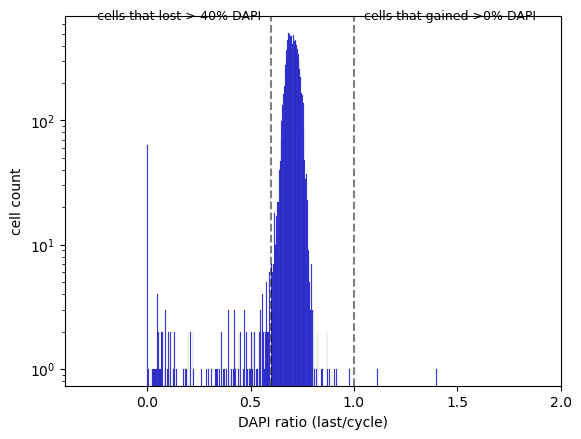

2025-01-15 12:31:07.883 | INFO     | filtering:filter_by_ratio:134 -  ---- filter_by_ratio is done, took 0s  ----


In [13]:
adata = filtering.filter_by_ratio(
    sdata['imaging'],
    end_cycle='DNA_8', 
    start_cycle="DNA_6", 
    label="DAPI", 
    min_ratio=0.6, max_ratio=1.00)

In [14]:
adata.obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,DNA_6_above_5000,DNA_6_below_25000,DNA_6_filter,shapes,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass
0,1,258.003817,1768.854962,262,18.967496,17.676168,0.362667,0.102867,0.811146,0.949275,True,True,True,mask_polygons,0.525626,False,True,False
1,2,662.910714,1071.553571,112,13.456567,10.658541,0.610430,-0.149277,0.783217,0.949153,True,True,True,mask_polygons,0.667224,True,True,True
2,3,667.654867,1109.185841,226,19.693311,15.227421,0.634128,1.009633,0.699690,0.900398,True,True,True,mask_polygons,0.724711,True,True,True
3,4,674.850220,1326.766520,227,17.455343,16.809391,0.269523,1.005338,0.700617,0.926531,True,True,True,mask_polygons,0.313422,False,True,False
4,5,676.988571,907.400000,175,16.430375,13.860761,0.536963,1.339714,0.729167,0.906736,False,True,False,mask_polygons,0.734265,True,True,True


## Filter by manual annotations

2025-01-15 12:31:07.907 | INFO     | filtering:filter_by_annotation:141 -  ---- filter_by_annotation : version number 1.3.0 ----
2025-01-15 12:31:08.011 | INFO     | filtering:filter_by_annotation:148 - GeoJson loaded, detected: 17 annotations
2025-01-15 12:31:08.083 | INFO     | filtering:filter_by_annotation:178 - Found 2 unique classes in the geojson file: ['Autofluorescence' 'CD16_cells']


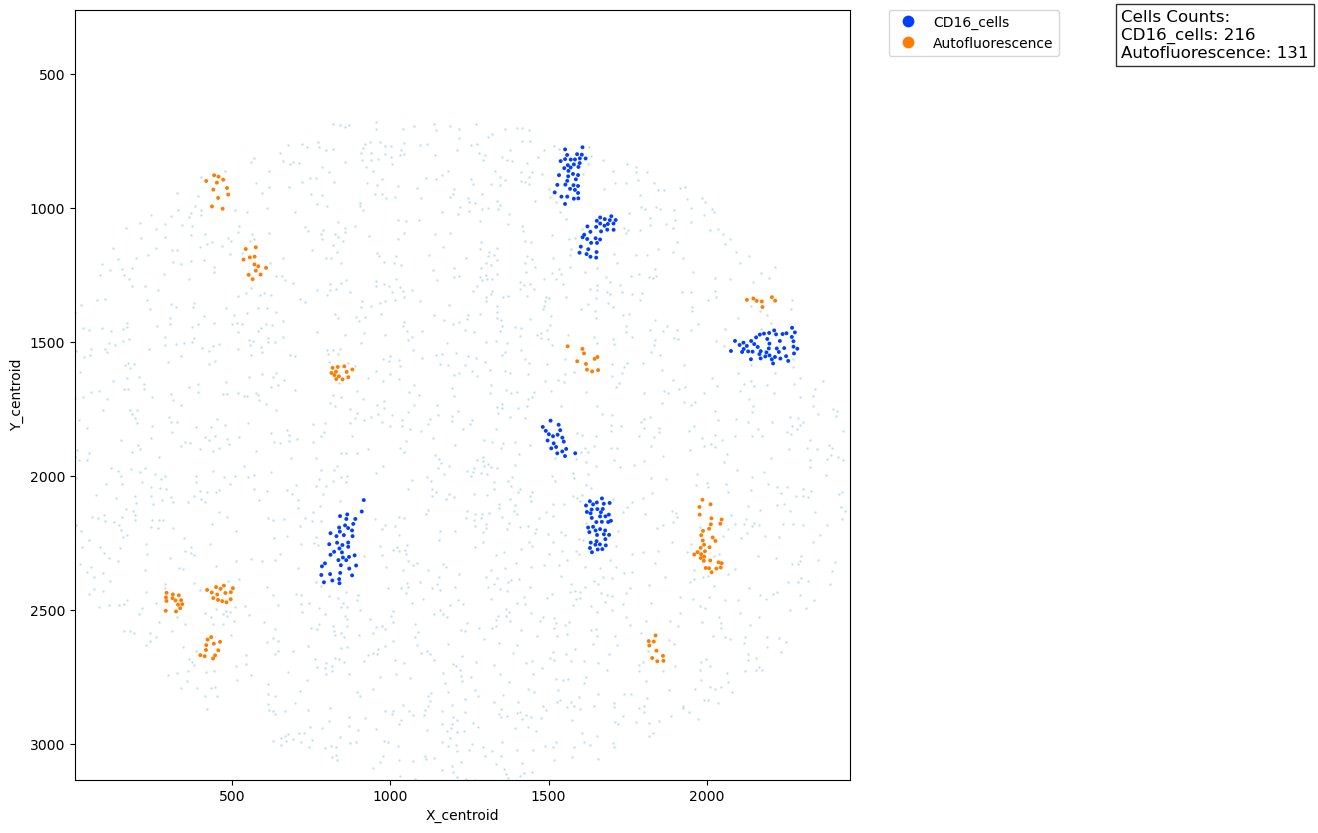

2025-01-15 12:31:12.298 | INFO     | filtering:filter_by_annotation:214 -  ---- filter_by_annotation is done, took 4s  ----


In [15]:
#needs geojson file, with some classifications
adata = filtering.filter_by_annotation(
    adata=sdata['imaging'],
    path_to_geojson="../data/geojsons/exemplar001/exemplar001_artefacts_wclasses.geojson")

In [16]:
sdata['imaging'].obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,DNA_6_above_5000,DNA_6_below_25000,DNA_6_filter,shapes,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,Autofluorescence,CD16_cells
0,1,258.003817,1768.854962,262,18.967496,17.676168,0.362667,0.102867,0.811146,0.949275,True,True,True,mask_polygons,0.525626,False,True,False,False,False
1,2,662.910714,1071.553571,112,13.456567,10.658541,0.610430,-0.149277,0.783217,0.949153,True,True,True,mask_polygons,0.667224,True,True,True,False,False
2,3,667.654867,1109.185841,226,19.693311,15.227421,0.634128,1.009633,0.699690,0.900398,True,True,True,mask_polygons,0.724711,True,True,True,False,False
3,4,674.850220,1326.766520,227,17.455343,16.809391,0.269523,1.005338,0.700617,0.926531,True,True,True,mask_polygons,0.313422,False,True,False,False,False
4,5,676.988571,907.400000,175,16.430375,13.860761,0.536963,1.339714,0.729167,0.906736,False,True,False,mask_polygons,0.734265,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9706,9707,3131.737589,1077.312057,141,15.062860,12.118068,0.593953,-0.221931,0.839286,0.927632,True,True,True,mask_polygons,0.718345,True,True,True,False,False
9707,9708,3128.972906,1131.268473,406,26.022461,20.595364,0.611240,-1.167795,0.678930,0.886463,True,True,True,mask_polygons,0.222806,False,True,False,False,False
9708,9709,3129.135780,1165.985321,545,31.945231,23.536272,0.676144,1.523968,0.677019,0.931624,True,True,True,mask_polygons,0.720562,True,True,True,False,False
9709,9710,3132.241706,1222.440758,211,19.084075,14.523770,0.648703,1.396324,0.793233,0.929515,True,True,True,mask_polygons,0.657270,True,True,True,False,False


## QC2: visualize the filtered cells

### Preparation 1: Transform the segmentation mask into polygons

In [17]:
# create shapes from mask
mask_polygons = spatialdata.to_polygons(sdata['mask'])
sdata['mask_polygons'] = spatialdata.models.ShapesModel.parse(mask_polygons)
# important to have same number of cells in imaging and mask
assert sdata['imaging'].shape[0] == sdata['mask_polygons'].shape[0], "Number of cells in imaging and mask do not match."
sdata

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:96: UserWarning:

Key `mask_polygons` already exists. Overwriting it in-memory.



SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/exemplar001/exemplar001.zarr
├── Images
│     └── 'image': DataArray[cyx] (12, 3139, 2511)
├── Labels
│     └── 'mask': DataArray[yx] (3139, 2511)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (9711, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (9711, 12)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), mask_polygons (Shapes)

### Preparation 2: Link quantification table to polygons

We now have to match the index of "sdata['mask_polygons']" to a column in adata.obs; this will be CellID, lets confirm they match

In [20]:
assert sdata['mask_polygons'].index.to_list()[:5] == sdata['imaging'].obs['CellID'].to_list()[:5], "First 5 CellIDs do not match."
assert sdata['mask_polygons'].index.to_list()[-5:] == sdata['imaging'].obs['CellID'].to_list()[-5:], "Last 5 CellIDs do not match."
assert sdata['mask_polygons'].index.dtype == sdata['imaging'].obs['CellID'].dtype, "Data types do not match."

In [21]:
# save into adata
adata = sdata['imaging'].copy()
# deleting in memory
del sdata['imaging']

In [27]:
adata.obs["shapes"] = "mask_polygons"
adata.obs["shapes"] = adata.obs["shapes"].astype("category")
table = spatialdata.models.TableModel.parse(adata, region = "mask_polygons", region_key = "shapes", instance_key = "CellID")
sdata["imaging"] = table

In [26]:
del adata.uns

In [29]:
# deleting and writing new table on disk, this might be a bad idea for large tables
# sdata.delete_element_from_disk("imaging")
sdata.write_element("imaging", overwrite=True)

#writing mask_polygons to disk
sdata.write_element("mask_polygons", overwrite=True)

ValueError: Cannot overwrite. The target path of the write operation is in use. Please save the data to a different location. 
Details: the target path in which to save an element is a subfolder of the current Zarr store.
Workaround: please see discussion here https://github.com/scverse/spatialdata/discussions/520 .

### Visualized filtered cells

In [30]:
# QC2 Visual check of filtered cells
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()

# Issue 1
# sdata['mask'] is not available in napari-spatialdata
# Issue 2
# unfortunately color palettes are still not available 
# See issue: https://github.com/scverse/napari-spatialdata/issues/324

Traceback (most recent call last):
  File "/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/napari_spatialdata/_sdata_widgets.py", line 97, in <lambda>
    self.elements_widget.itemDoubleClicked.connect(lambda item: self._onClick(item.text()))
                                                                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/napari_spatialdata/_sdata_widgets.py", line 121, in _onClick
    self.viewer_model.add_sdata_labels(sdata, text, selected_cs, multi)
  File "/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/napari_spatialdata/_viewer.py", line 631, in add_sdata_labels
    adata, table_name, table_names = self._get_table_data(sdata, original_name)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/